In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import cmocean
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr

import warnings
import CM4Xutils
import sectionate as sec
import regionate as reg
import tosnap

import xbudget
import xwmb

In [3]:
atl = reg.open_grs("../data/Atlantic.grs", CM4Xutils.ds_to_grid)

Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`


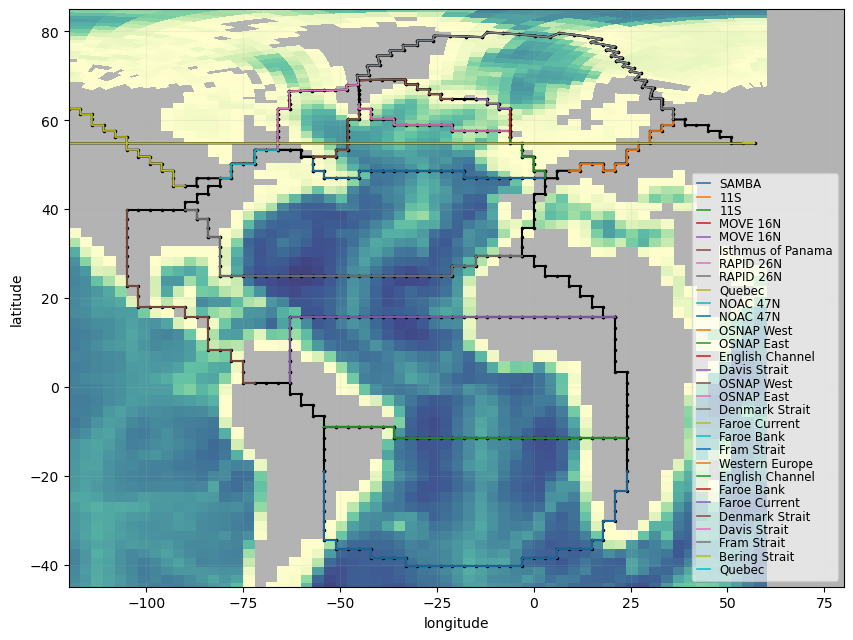

In [9]:
cmap = cmocean.cm.deep.copy()
cmap.set_bad((0.7, 0.7, 0.7))

plt.figure(figsize=(10, 7.5))

ax = plt.subplot(facecolor=(0.7, 0.7, 0.7))
plt.pcolor(
    atl.grid._ds['geolon_c'],
    atl.grid._ds['geolat_c'],
    atl.grid._ds['deptho'].where(atl.grid._ds['deptho']>0),
    cmap=cmap, vmin=0, vmax=7500,
)
plt.xlim(-120, 80)
plt.ylim(-45, 85)

for region_name, region in atl.region_dict.items():
    lons, lats = reg.loop(region.lons), reg.loop(region.lats)
    plt.plot(lons, lats, "k.-", markersize=3, linewidth=1.5)
    for child_name, child in region.children.items():
        plt.plot(child.lons, child.lats, "-", label=child_name, linewidth=1.2)
    
plt.legend(loc="lower right", handlelength=1.1, labelspacing=0.025, fontsize=8.5, framealpha=0.65)
plt.grid(True, alpha=0.15)
plt.xlabel("longitude")
plt.ylabel("latitude");
plt.savefig("../figures/AtlantOS_arrays.png", bbox_inches="tight", dpi=200)